In [35]:
directory='c:/users/da1933/desktop/cds/ids_project/'
#directory='~/desktop/idsproject/'

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing,neighbors, datasets
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib.colors import ListedColormap

## Climate Historical Data

In [27]:
%%capture
'''
For reducing large temp file
df=pd.read_csv('climate/GlobalLandTemperaturesByCity.csv',low_memory=False,parse_dates={'date':[0]})  
df=df[df['date']>=datetime.date(1950,1,1)]  
df=df[pd.notnull(df['AverageTemperature'])]  
df.to_excel('climate/LandTempByCityPost1950.xlsx')

df=pd.read_excel('LandTempByCityPost1950.xlsx',parse_dates=[0])
df['year']=df['date'].apply(lambda x: x.year)
average_temp=df.groupby(['Country','City','year'])['AverageTemperature'].mean().unstack().reset_index()
latlong=df[['Country','City','Latitude','Longitude']].drop_duplicates().reset_index(drop=True)
average_temp=pd.merge(average_temp,latlong,how='left',on=['Country','City'])
average_temp=average_temp[list(average_temp.columns[:2])+\
                          list(average_temp.columns[-2:])+\
                          list(average_temp.columns[2:-2])]
average_temp.to_csv('climate/yearly_averages.csv',index=False)
'''

In [237]:
def tempfeatures(df):
    df['change']=df['2013']-df['1950']
    df['rate']=df['change']/df['1950']
    return df

clim=pd.read_csv(directory+'climate/yearly_averages.csv')
clim=clim.drop(clim.columns[0],1)

clim=tempfeatures(clim)

In [239]:
clim.head()

Country       City Latitude Longitude       1950       1951       1952  \
0  Afghanistan     Baglan   36.17N    69.61E   9.965167  10.828500  11.151000   
1  Afghanistan     Gardez   32.95N    69.89E  16.307833  17.335917  17.679500   
2  Afghanistan      Gazni   32.95N    67.98E   9.275167  10.336583  10.657750   
3  Afghanistan      Herat   34.56N    62.27E  13.226250  14.053333  14.173167   
4  Afghanistan  Jalalabad   34.56N    70.05E  13.507000  14.414917  14.729500   

        1953       1954       1955    ...          2006       2007       2008  \
0  11.360333  10.505917  11.466083    ...     12.375167  12.065917  12.011083   
1  18.065000  17.253500  17.487667    ...     18.485417  18.309500  18.248167   
2  11.207500  10.186583  10.763000    ...     11.702750  11.345333  11.452750   
3  14.576750  13.669833  15.109917    ...     15.957417  15.196667  15.312000   
4  15.076917  14.241667  14.724750    ...     15.798500  15.518000  15.479250   

        2009       2010       2011       2012       2013    change      rate  
0  11.628417  12.321917  12.266333  10.973333  13.113375  3.148208  0.315921  
1  18.182417  18.673333  18.576417  17.497167  18.843875  2.536042  0.155511  
2  11.321750  11.999333  11.847250  10.451000  12.178875  2.903708  0.313063  
3  15.774000  16.355083  15.527167  15.112917  17.350750  4.124500  0.311842  
4  15.093333  15.676000  15.812167  14.510333  16.206125  2.699125  0.199832  

[5 rows x 70 columns]

## World Development Indicators

In [ ]:
df=pd.read_csv(directory+'wdindicators/WDIData.csv',low_memory=False)

In [ ]:
cats=list(set(df['Indicator Name']))

In [ ]:
years=[pd.notnull(df[i]) for i in df.columns[4:-1]]

In [ ]:
df.dropna(axis=0,how=all,subset=df.columns[4:-1])

In [ ]:
# There are 1600 indicators
# Can search for interesting indicators with keywords as follows:
[i for i in cats if 'mortality' in i.lower()]

***

## Ecological Footprint

In [64]:
country_names={'Bosnia and Herzegovina':'Bosnia And Herzegovina',"Côte d'Ivoire":"Côte D'Ivoire",
               'Congo, Democratic Republic of':'Congo (Democratic Republic Of The)','Guinea-Bissau':'Guinea Bissau',
               'Iran, Islamic Republic of':'Iran','Libyan Arab Jamahiriya':'Libya','Russian Federation':'Russia',
               'Syrian Arab Republic':'Syria','Tanzania, United Republic of':'Tanzania',
               'United States of America':'United States','Venezuela, Bolivarian Republic of':'Venezuela',
               'Viet Nam':'Vietnam'}

In [84]:
ec=pd.read_csv(directory+'ecol/NFA 2018.csv')
ec['country']=ec['country'].replace(country_names)
ec=ec[pd.notnull(ec['grazing_land'])]
world=ec[ec['UN_region']=='World']
ec=ec[ec['UN_region']!='World']

ec=ec.rename(columns={'country':'Country'})

newrecords={'EFImportsPerCap':'IMcap','EFExportsPerCap':'EXcap','EFConsPerCap':'CONScap','EFExportsTotGHA':'EXhec',
            'EFProdPerCap':'PRODcap','EFImportsTotGHA':'IMhec','BiocapPerCap':'BIOcap','EFConsTotGHA':'CONShec',
            'EFProdTotGHA':'PRODhec','BiocapTotGHA':'BIOhec'}

ec['record']=ec['record'].map(newrecords)
ec=ec[ec['Country'].isin(set(countryclim['Country'])&set(ec['Country']))]
fts=list(ec.columns[6:12])

In [92]:
countryclim=clim.groupby(['Country']).mean().reset_index()
countryclim=tempfeatures(countryclim)

merged=pd.merge(ec,countryclim[['Country','change']],how='left',on='Country')
merged['Y']=merged['change'].apply(lambda x: 2 if x>2 else (1 if x>1 else 0)).reset_index(drop=True)
#data=pd.DataFrame(preprocessing.scale(merged[fts]),columns=fts)
data=merged[fts].copy()
data['Y']=merged['Y']
data['record']=merged['record']

In [133]:
q=merged.groupby(['Country','record','year']).sum().unstack()

In [190]:
q.head(10)

crop_land                                            \
year                         1961          1962          1963          1964   
Country     record                                                            
Afghanistan BIOcap   5.445512e-01  5.157814e-01  4.770274e-01  4.937238e-01   
            BIOhec   4.990785e+06  4.819343e+06  4.546811e+06  4.803261e+06   
            CONScap  5.388636e-01  5.063614e-01  4.749578e-01  4.961201e-01   
            CONShec  4.938658e+06  4.731324e+06  4.527084e+06  4.826574e+06   
            EXcap    1.247236e-02  1.292504e-02  1.522080e-02  1.411298e-02   
            EXhec    1.143085e+05  1.207686e+05  1.450778e+05  1.373001e+05   
            IMcap    6.784705e-03  3.504974e-03  1.315122e-02  1.650926e-02   
            IMhec    6.218149e+04  3.274967e+04  1.253515e+05  1.606126e+05   
            PRODcap  5.445512e-01  5.157814e-01  4.770274e-01  4.937238e-01   
            PRODhec  4.990785e+06  4.819343e+06  4.546811e+06  4.803261e+06   

                                                                             \
year                         1965          1966          1967          1968   
Country     record                                                            
Afghanistan BIOcap   5.017452e-01  4.502375e-01  4.850026e-01  4.778992e-01   
            BIOhec   4.985019e+06  4.569370e+06  5.028797e+06  5.065636e+06   
            CONScap  5.070287e-01  4.564691e-01  4.990556e-01  4.844933e-01   
            CONShec  5.037512e+06  4.632613e+06  5.174507e+06  5.135532e+06   
            EXcap    1.199659e-02  1.492293e-02  1.316157e-02  1.408985e-02   
            EXhec    1.191904e+05  1.514498e+05  1.364670e+05  1.493495e+05   
            IMcap    1.728007e-02  2.115451e-02  2.721456e-02  2.068395e-02   
            IMhec    1.716837e+05  2.146928e+05  2.821769e+05  2.192458e+05   
            PRODcap  5.017452e-01  4.502375e-01  4.850026e-01  4.778992e-01   
            PRODhec  4.985019e+06  4.569370e+06  5.028797e+06  5.065636e+06   

                                                ...     Y                      \
year                         1969          1970 ...  2005 2006 2007 2008 2009   
Country     record                              ...                             
Afghanistan BIOcap   4.975859e-01  4.267907e-01 ...   2.0  2.0  2.0  2.0  2.0   
            BIOhec   5.398559e+06  4.746382e+06 ...   2.0  2.0  2.0  2.0  2.0   
            CONScap  5.069468e-01  4.360239e-01 ...   2.0  2.0  2.0  2.0  2.0   
            CONShec  5.500119e+06  4.849066e+06 ...   2.0  2.0  2.0  2.0  2.0   
            EXcap    1.456922e-02  1.236832e-02 ...   2.0  2.0  2.0  2.0  2.0   
            EXhec    1.580687e+05  1.375493e+05 ...   2.0  2.0  2.0  2.0  2.0   
            IMcap    2.393006e-02  2.160152e-02 ...   2.0  2.0  2.0  2.0  2.0   
            IMhec    2.596292e+05  2.402327e+05 ...   2.0  2.0  2.0  2.0  2.0   
            PRODcap  4.975859e-01  4.267907e-01 ...   2.0  2.0  2.0  2.0  2.0   
            PRODhec  5.398559e+06  4.746382e+06 ...   2.0  2.0  2.0  2.0  2.0   

                                              
year                2010 2011 2012 2013 2014  
Country     record                            
Afghanistan BIOcap   2.0  2.0  2.0  2.0  2.0  
            BIOhec   2.0  2.0  2.0  2.0  2.0  
            CONScap  2.0  2.0  2.0  2.0  2.0  
            CONShec  2.0  2.0  2.0  2.0  2.0  
            EXcap    2.0  2.0  2.0  2.0  2.0  
            EXhec    2.0  2.0  2.0  2.0  2.0  
            IMcap    2.0  2.0  2.0  2.0  2.0  
            IMhec    2.0  2.0  2.0  2.0  2.0  
            PRODcap  2.0  2.0  2.0  2.0  2.0  
            PRODhec  2.0  2.0  2.0  2.0  2.0  

[10 rows x 594 columns]

In [221]:
# To Do: create columns for change in each record from earliest to latest year

q['crop_land'][2014].loc['Afghanistan'].loc['IMhec']-q['crop_land'][1961].loc['Afghanistan'].loc['IMhec']

q['crop_land'].loc['Afghanistan'][1961].loc['IMhec']

In [172]:
q['crop_land'].loc['Afghanistan'].loc['BIOcap'].index

Int64Index([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
           dtype='int64', name='year')

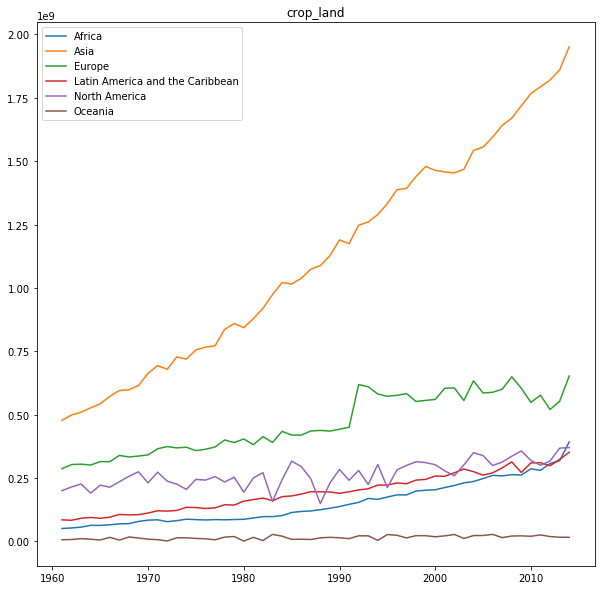

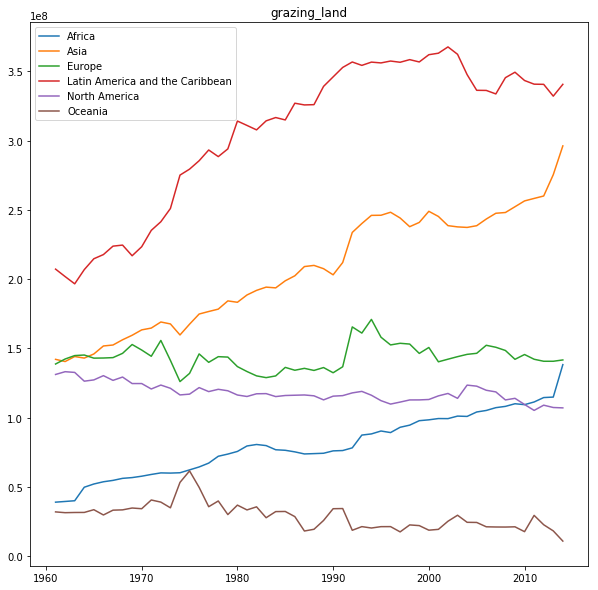

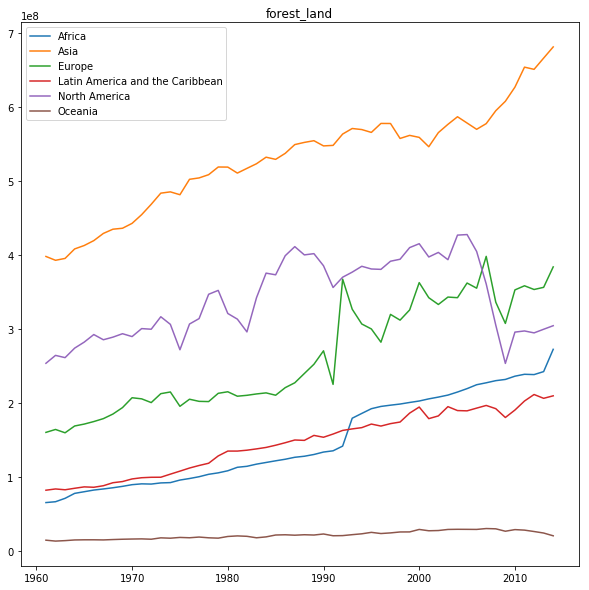

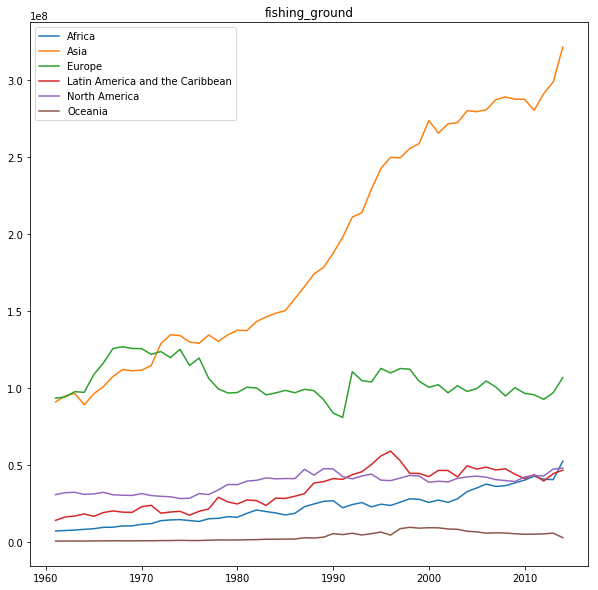

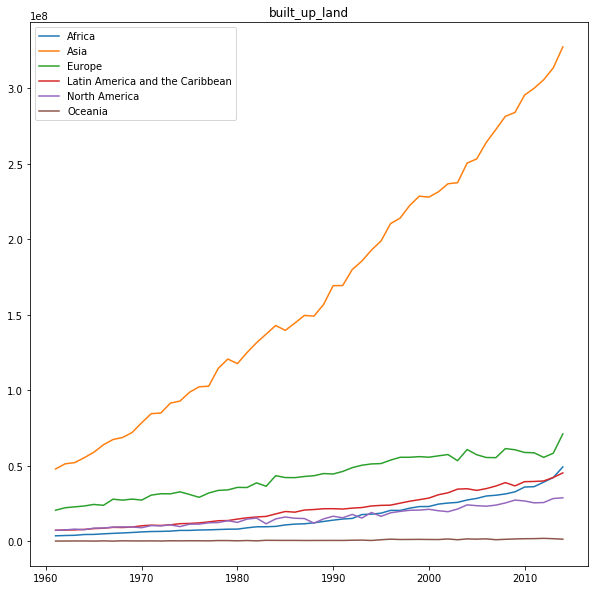

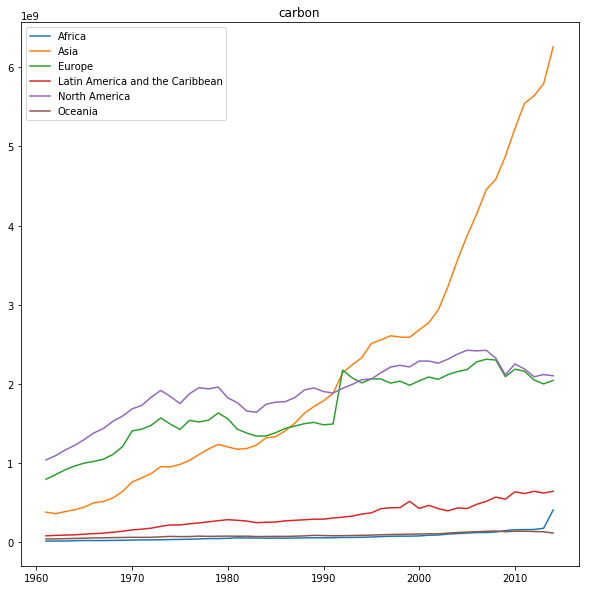

In [83]:
for feat in fts:
    carb=ec[ec['record']=='CONShec'].groupby(['UN_region','year'])[feat].sum().unstack()
    plt.figure(figsize=(10,10))
    for loc in carb.index:
        plt.plot(carb.columns,carb.loc[loc],label=loc)
    plt.legend()
    plt.title(feat)
    plt.show()

In [87]:
sets={i:mergedVecs[mergedVecs['record']==i].drop('record',axis=1).copy().reset_index(drop=True) for i in set(mergedVecs['record'])}
sets.keys()

dict_keys(['PRODhec', 'CONScap', 'PRODcap', 'EXcap', 'CONShec', 'IMcap', 'EXhec', 'IMhec', 'BIOhec', 'BIOcap'])

In [89]:
split_index=int(np.round(sets['CONShec'].shape[0]*.7))

for measure in ['PRODhec','CONShec']:
    sets[measure]=sets[measure].set_index(np.random.permutation(sets[measure].index.values)).sort_index()
    X=sets[measure].iloc[:split_index,:-1]
    y=sets[measure].iloc[:split_index,-1]
    Xtest=sets[measure].iloc[split_index:,:-1]
    ytest=sets[measure].iloc[split_index:,-1]

    clf=neighbors.KNeighborsClassifier(20,weights='uniform').fit(X,y)
    
    tracc=sum(clf.predict(X)==y)/sets[measure].shape[0]
    acc=sum(clf.predict(Xtest)==ytest)/sets[measure].shape[0]
    print(measure,tracc,acc)

PRODhec 0.62816553428042 0.26477249330862673
CONShec 0.6147827877290508 0.255301626518427


In [222]:
avgec=ec.drop(['population','total','Percapita GDP (2010 USD)'],axis=1).\
            groupby(['Country','record']).mean().drop('year',axis=1).reset_index()

In [223]:
merged=pd.merge(avgec,countryclim[['Country','change']],how='left',on='Country')

In [224]:
merged['Y']=merged['change'].apply(lambda x: 2 if x>2 else (1 if x>1 else 0)).reset_index(drop=True)

In [225]:
mergedVecs=pd.DataFrame(preprocessing.scale(merged[fts]),columns=fts)
mergedVecs=mergedVecs[fts].copy()
mergedVecs['Y']=merged['Y']
mergedVecs['record']=merged['record']

In [226]:
sets={i:mergedVecs[mergedVecs['record']==i].drop('record',axis=1).copy().reset_index(drop=True) for i in set(mergedVecs['record'])}
sets.keys()

dict_keys(['PRODhec', 'CONScap', 'PRODcap', 'EXcap', 'CONShec', 'IMcap', 'EXhec', 'IMhec', 'BIOhec', 'BIOcap'])

In [232]:
split_index=int(np.round(sets['CONShec'].shape[0]*.7))

In [233]:
for measure in ['PRODhec','CONShec']:
    sets[measure]=sets[measure].set_index(np.random.permutation(sets[measure].index.values)).sort_index()
    X=sets[measure].iloc[:split_index,:-1]
    y=sets[measure].iloc[:split_index,-1]
    Xtest=sets[measure].iloc[split_index:,:-1]
    ytest=sets[measure].iloc[split_index:,-1]

    clf=neighbors.KNeighborsClassifier(14,weights='uniform').fit(X,y)
    
    tracc=sum(clf.predict(X)==y)/sets[measure].shape[0]
    acc=sum(clf.predict(Xtest)==ytest)/sets[measure].shape[0]
    print(measure,tracc,acc)

PRODhec 0.3793103448275862 0.12931034482758622
CONShec 0.3793103448275862 0.13793103448275862


In [ ]:
clf.score(Xtest,ytest)

In [234]:
X=sets['EXcap'].iloc[:split_index,:-1]
y=sets['EXcap'].iloc[:split_index,-1]
Xtest=sets['EXcap'].iloc[split_index:,:-1]
ytest=sets['EXcap'].iloc[split_index:,-1]

clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X, y)

In [235]:
acc=sum(clf.predict(Xtest)==ytest)/sets['EXcap'].shape[0]
print('EXcap',acc)

EXcap 0.10344827586206896


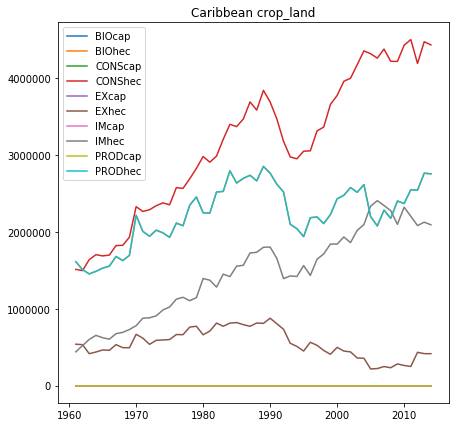

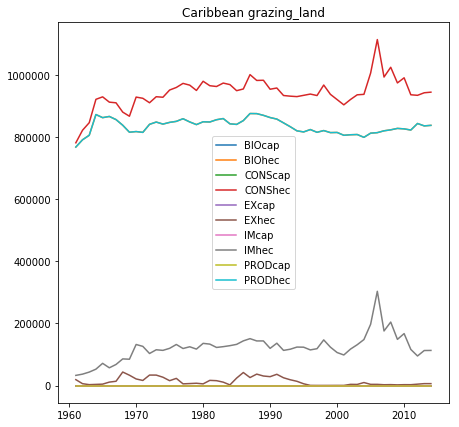

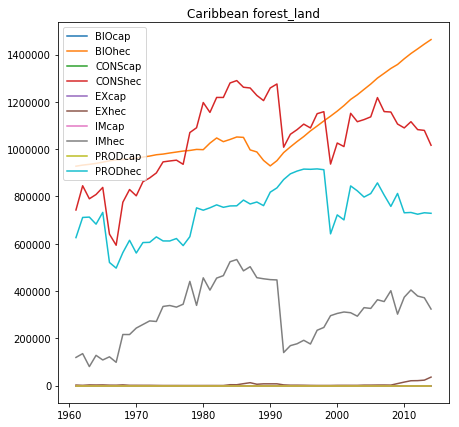

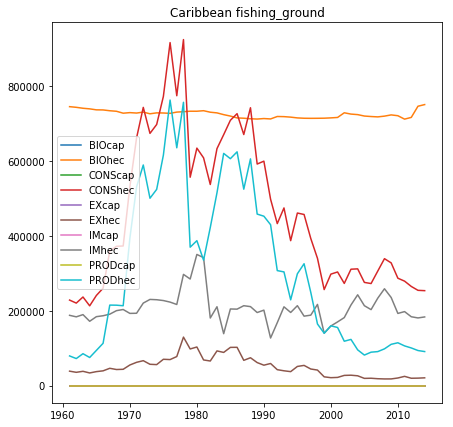

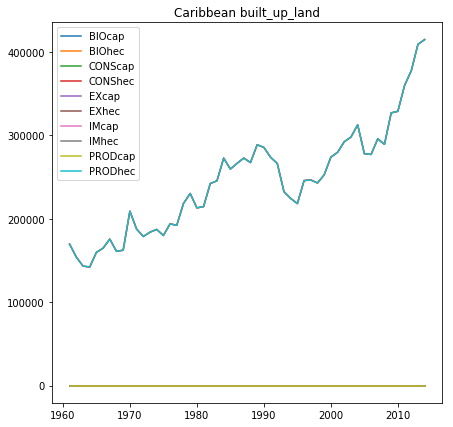

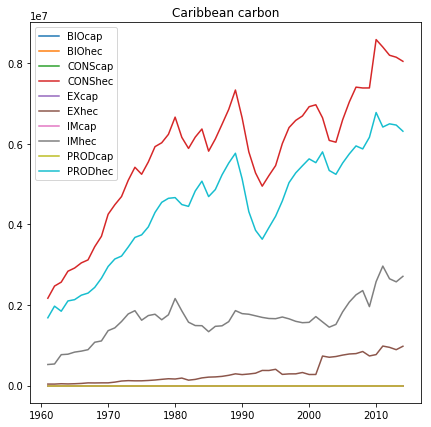

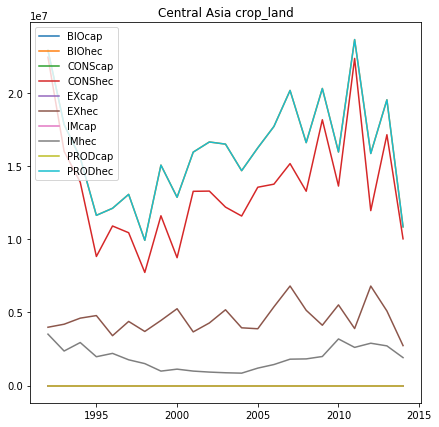

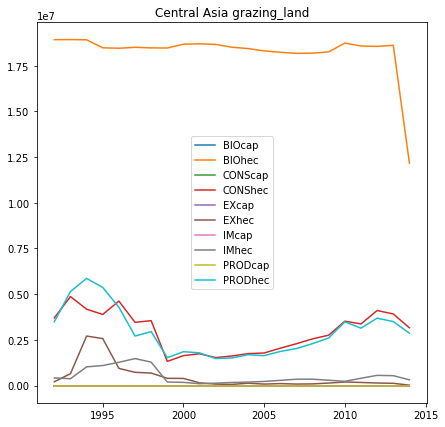

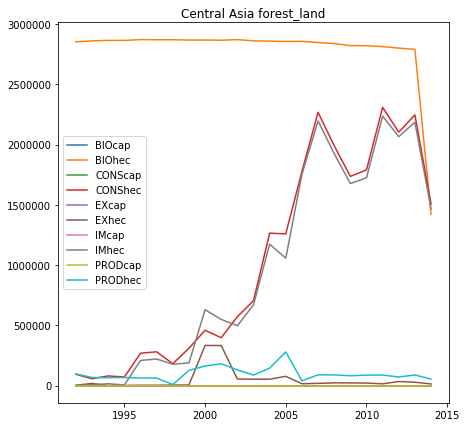

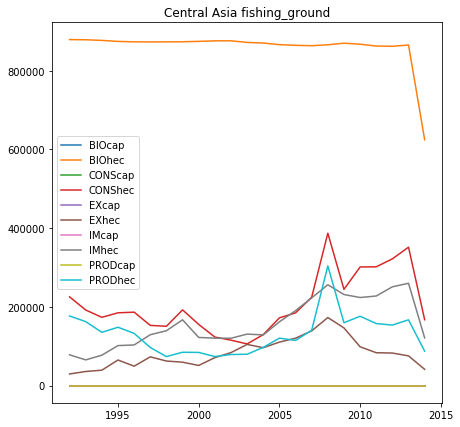

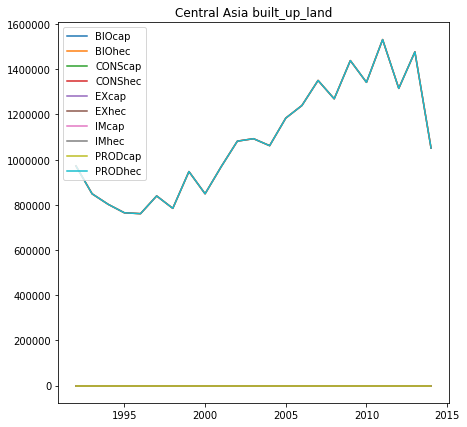

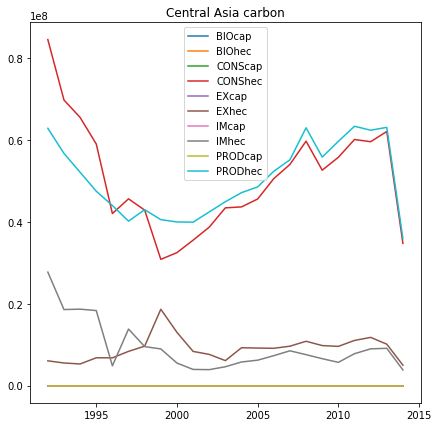

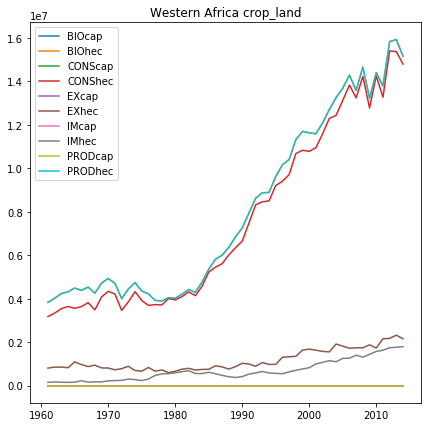

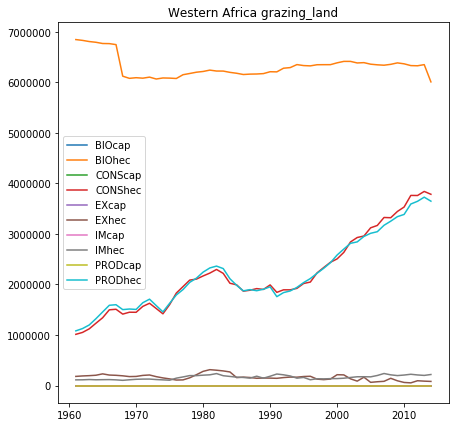

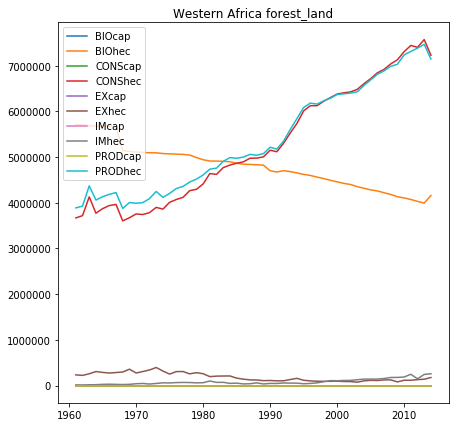

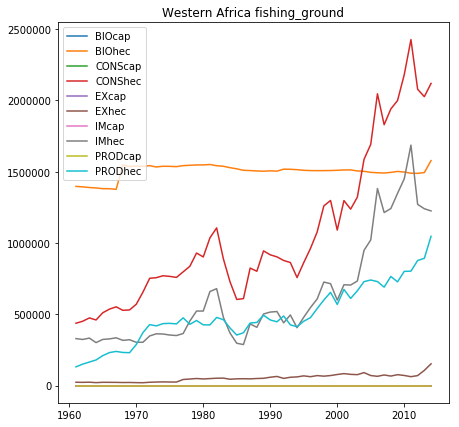

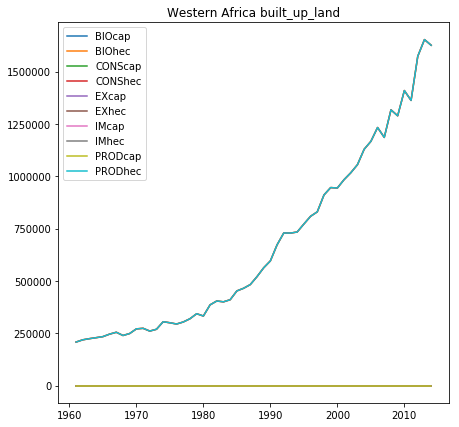

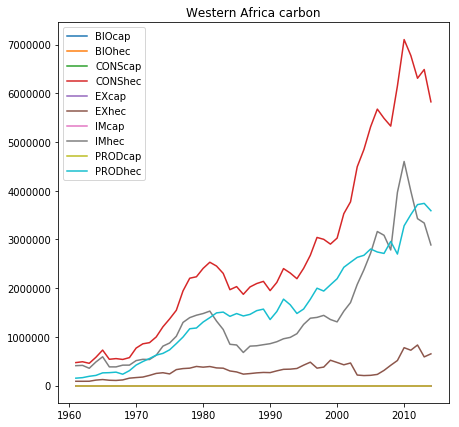

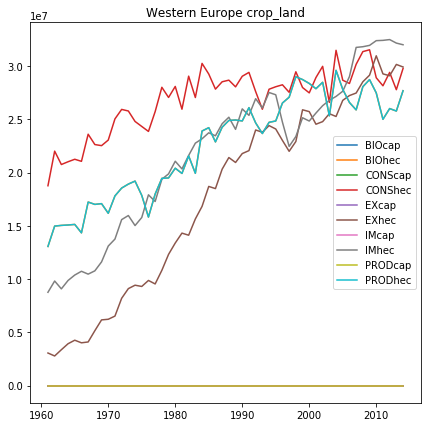

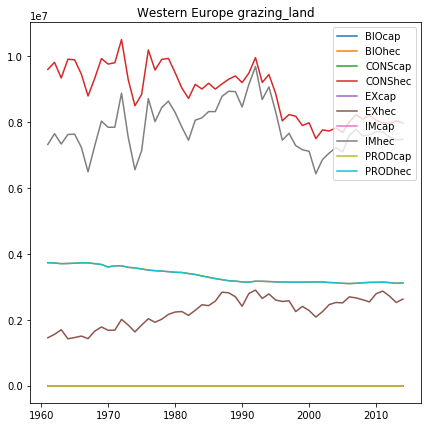

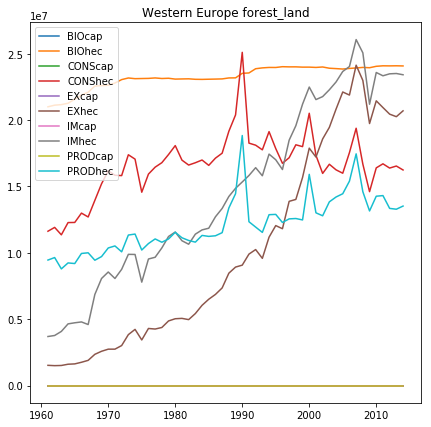

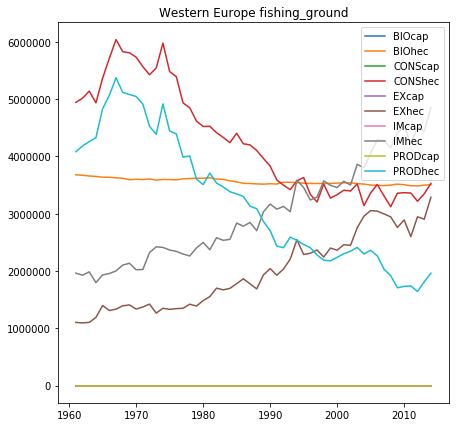

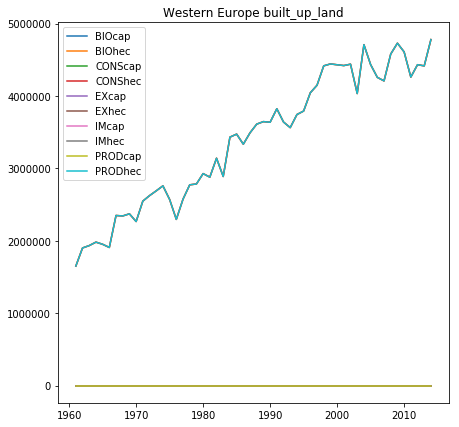

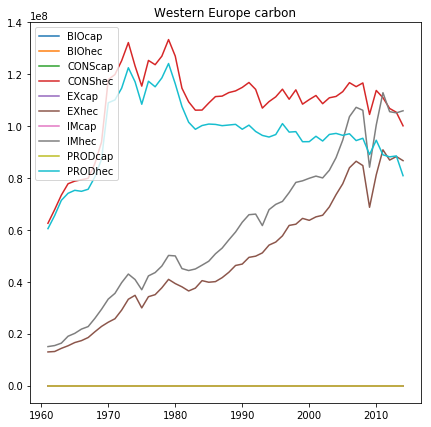

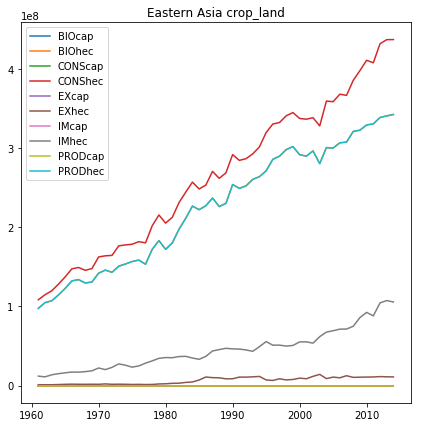

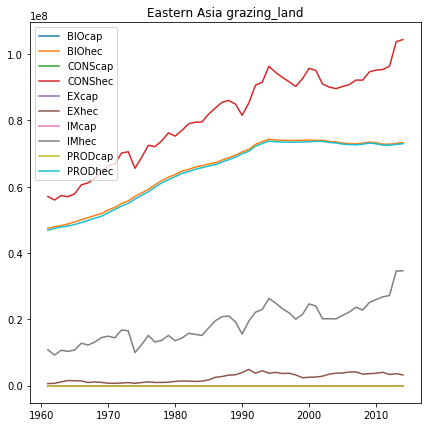

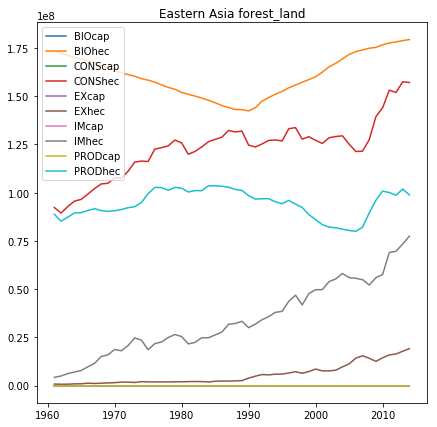

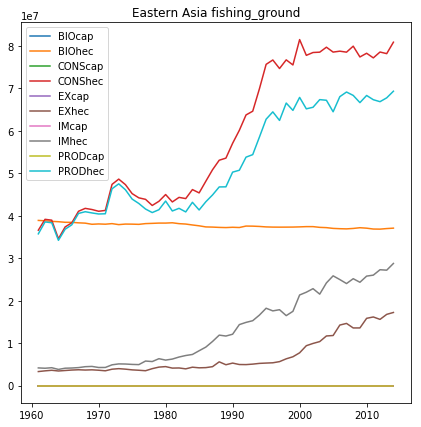

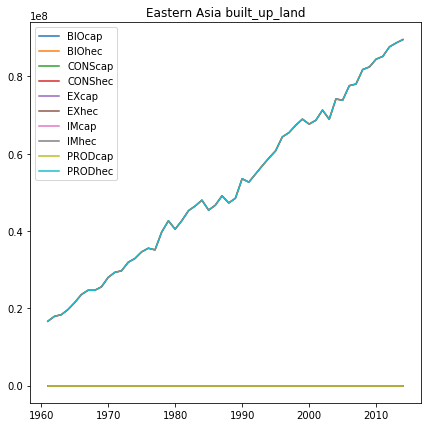

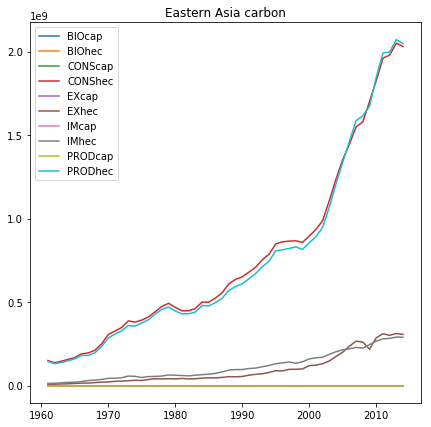

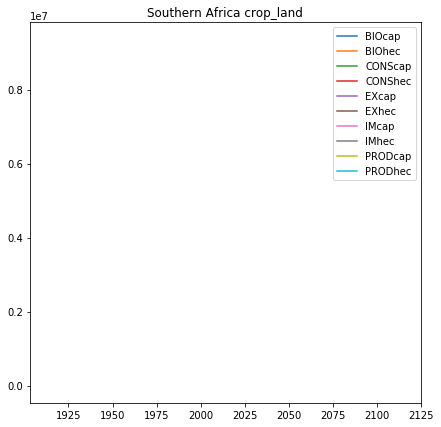

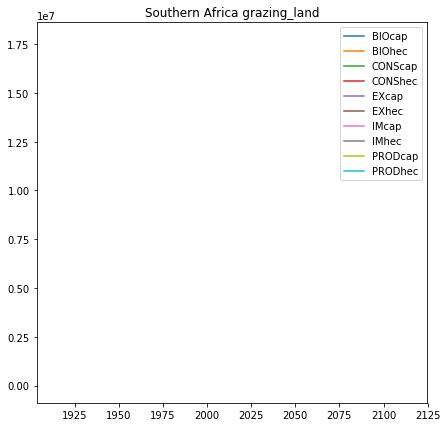

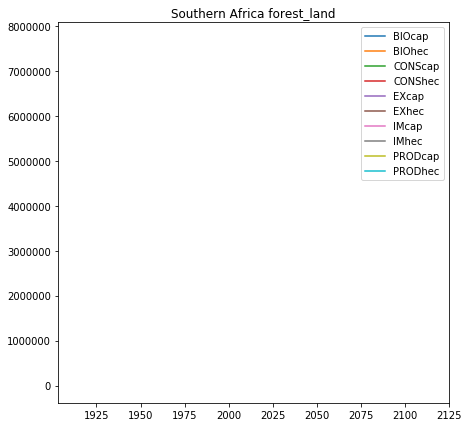

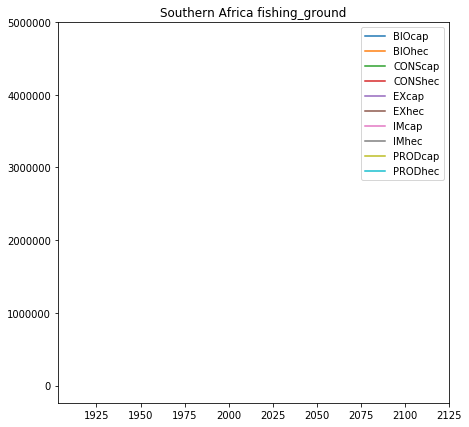

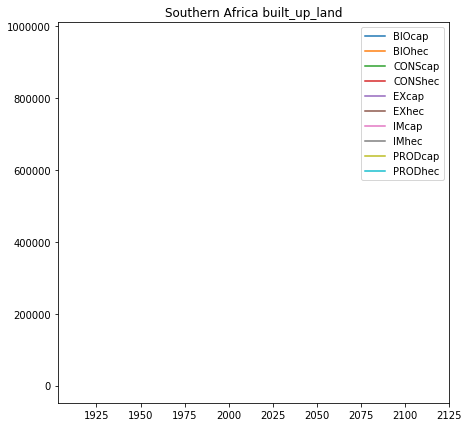

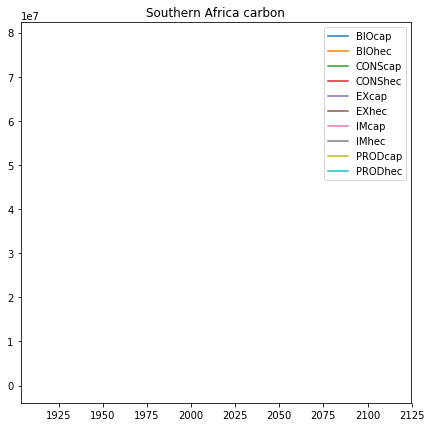

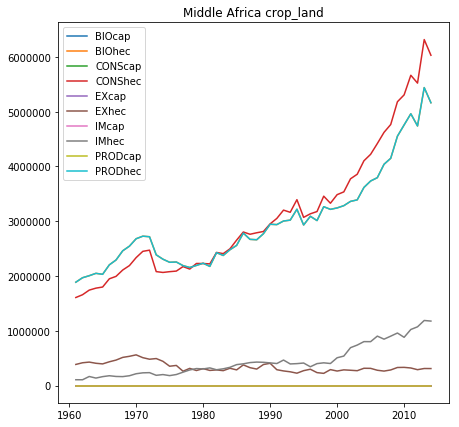

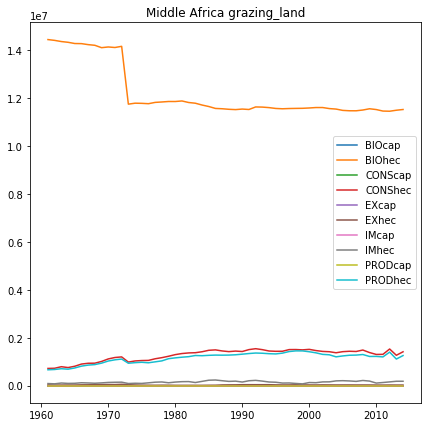

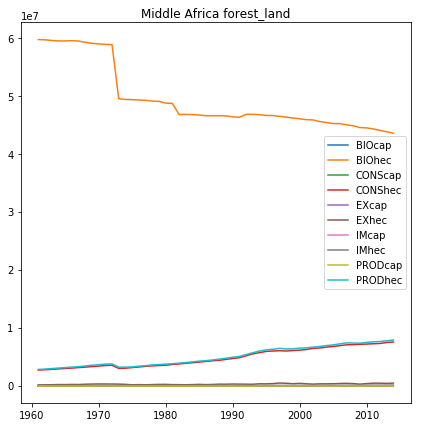

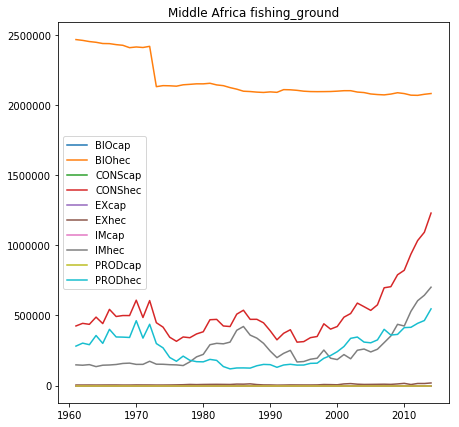

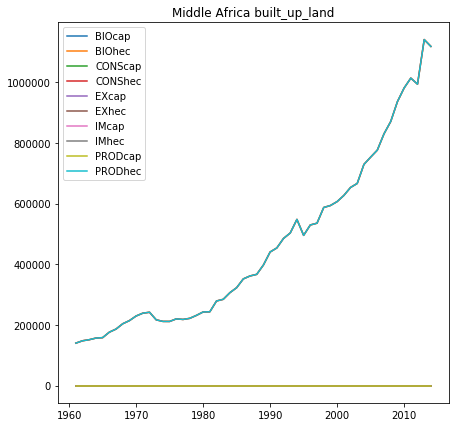

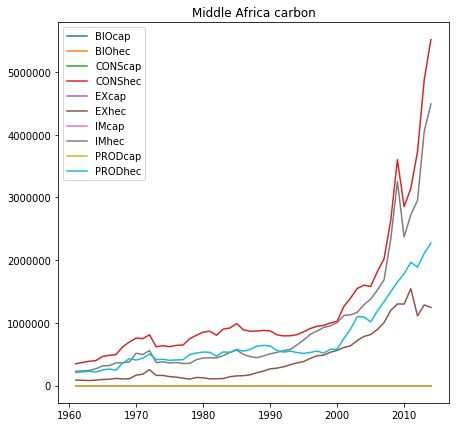

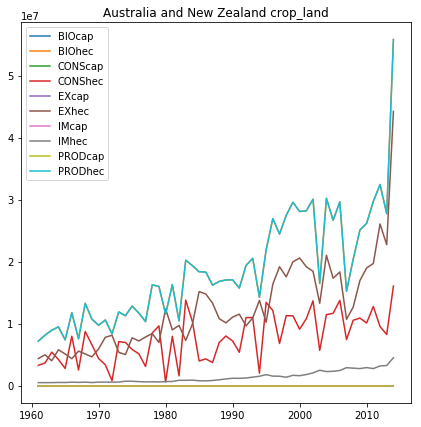

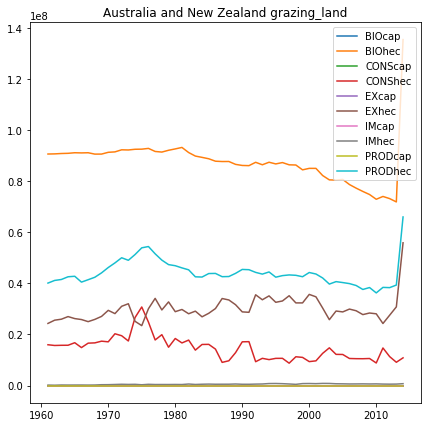

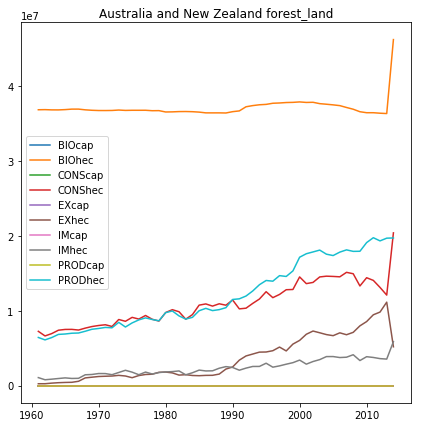

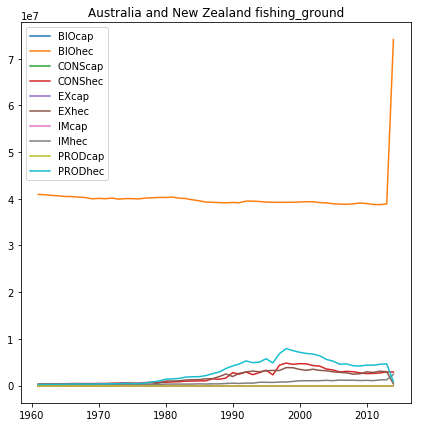

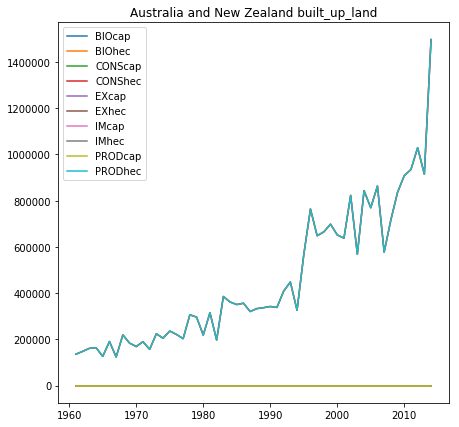

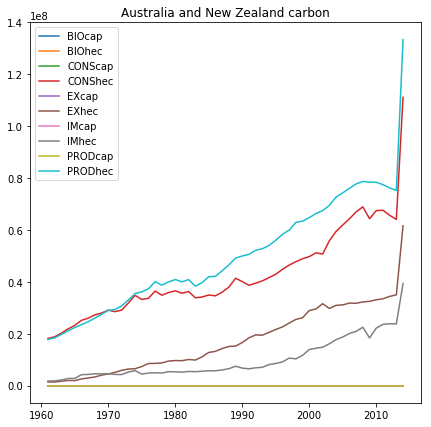

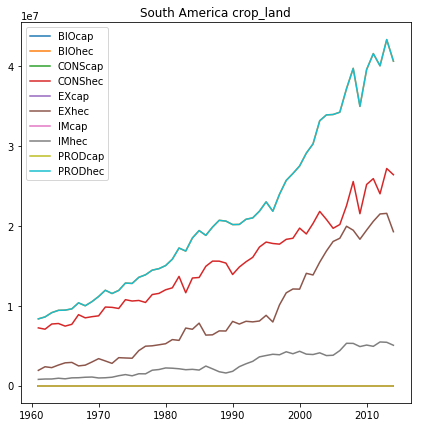

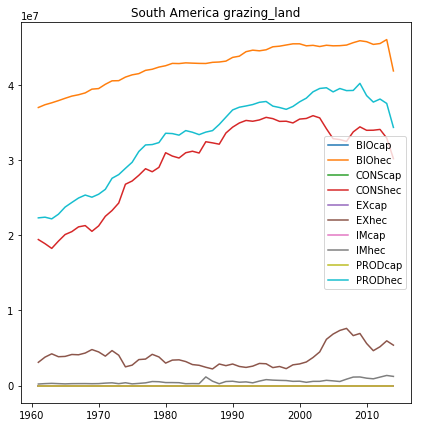

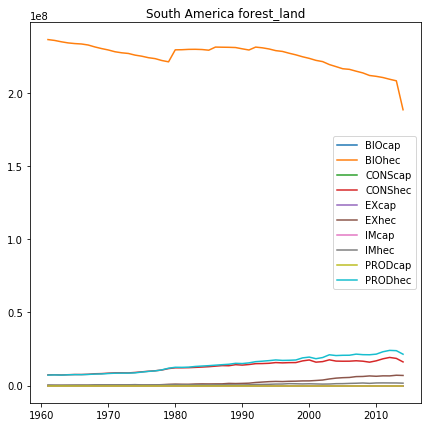

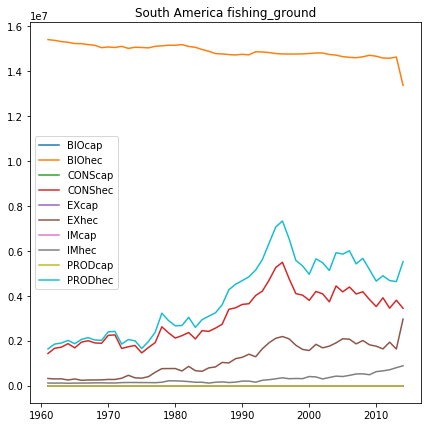

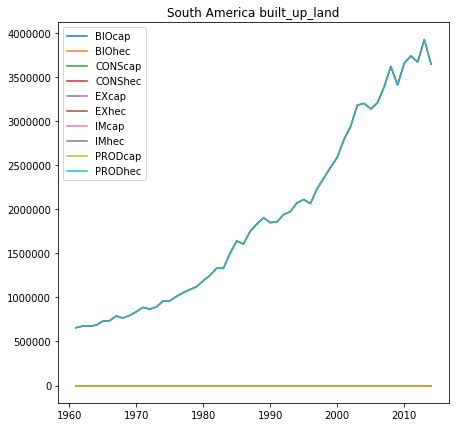

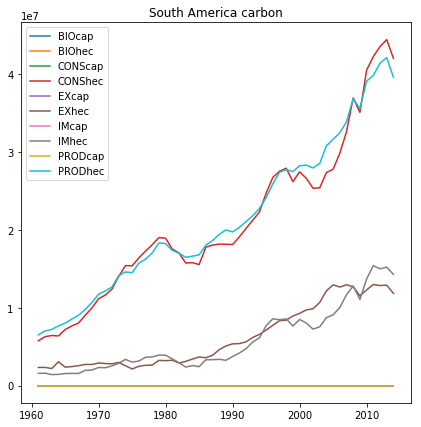

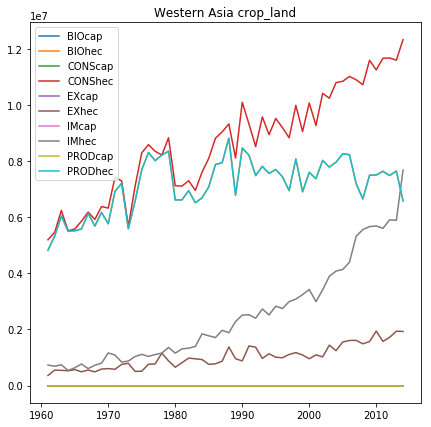

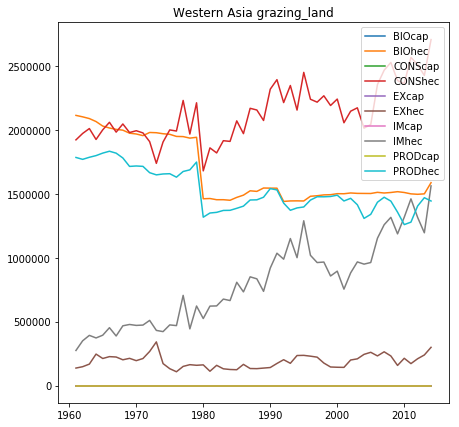

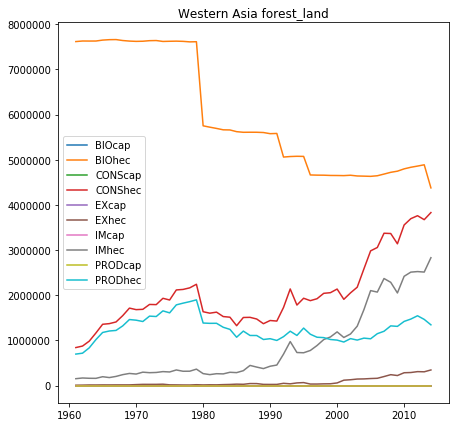

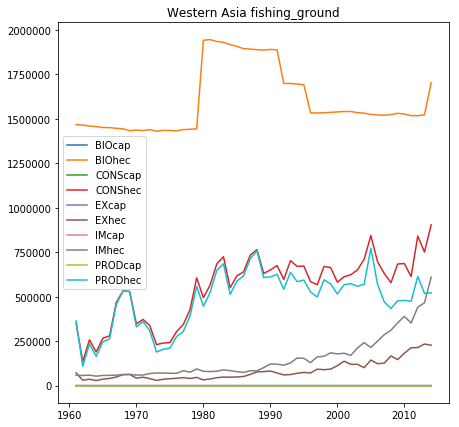

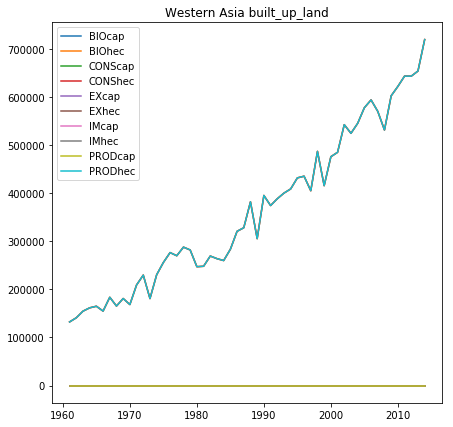

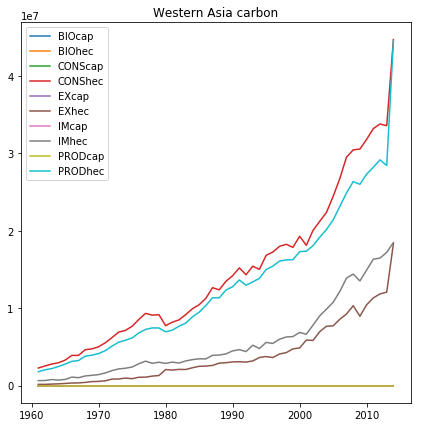

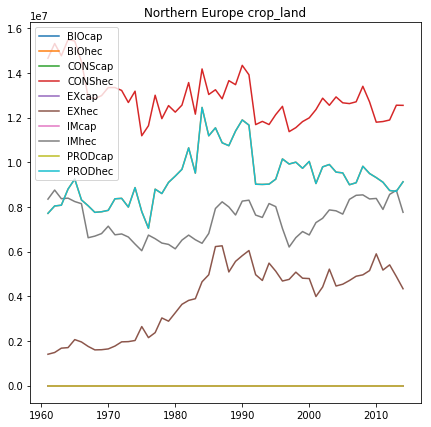

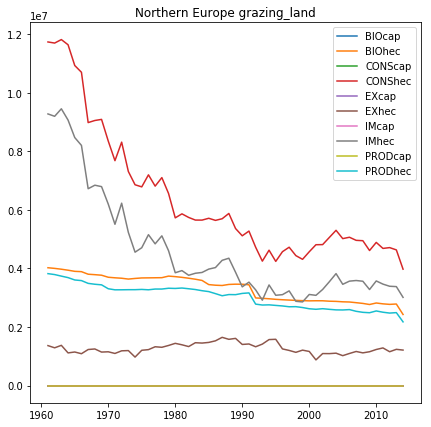

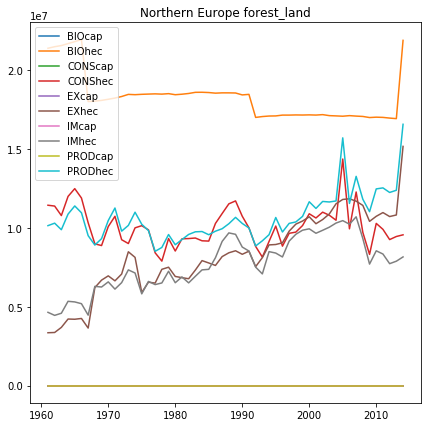

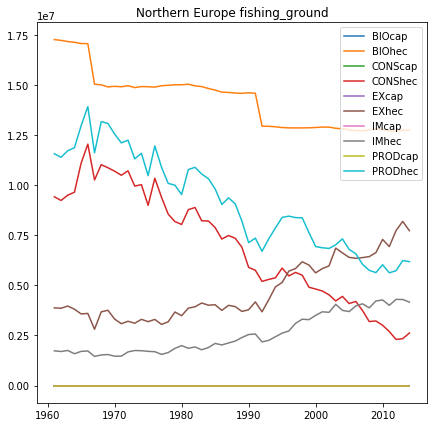

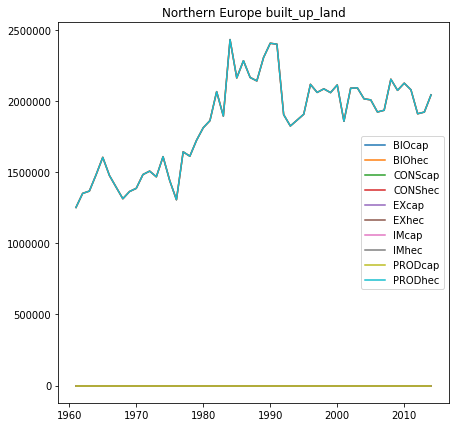

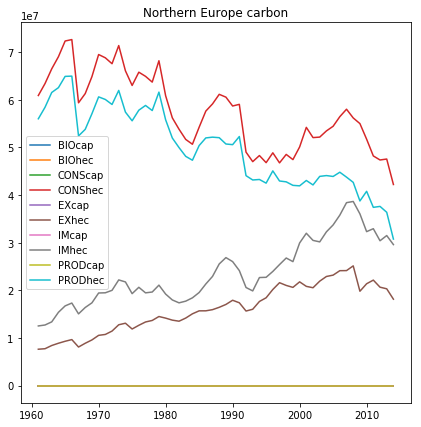

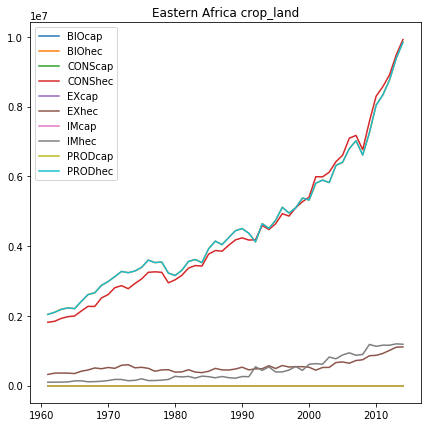

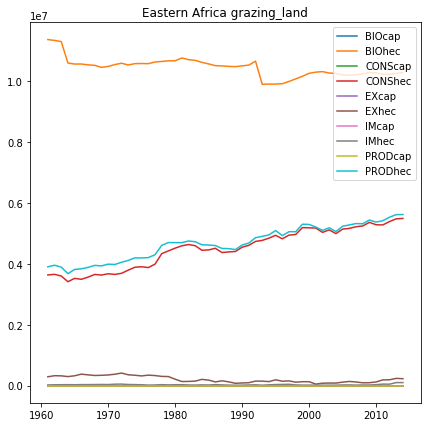

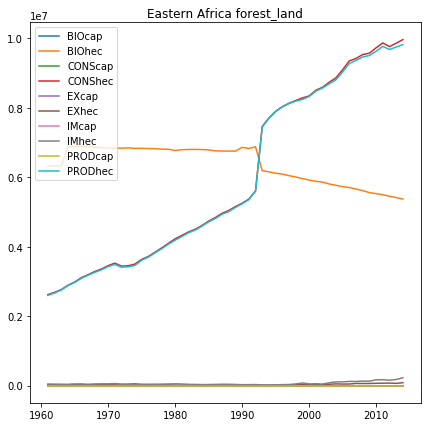

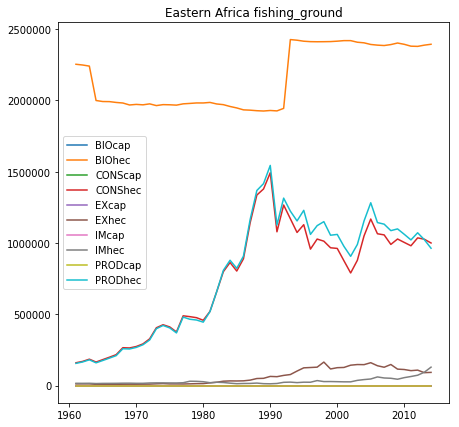

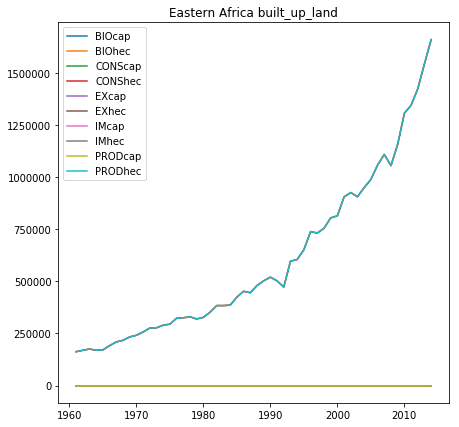

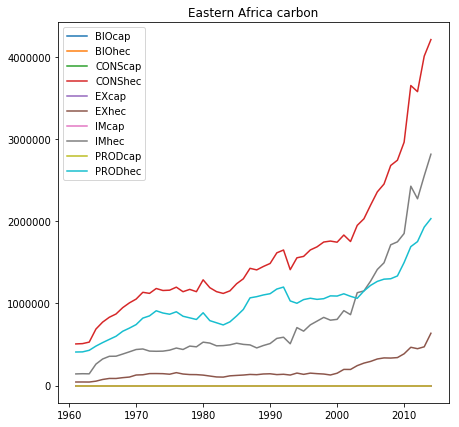

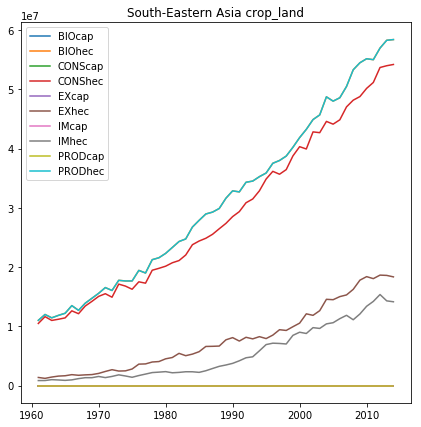

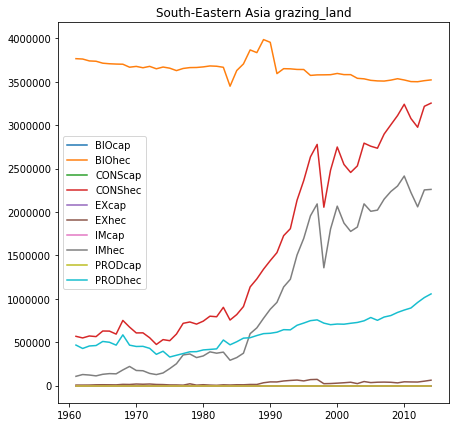

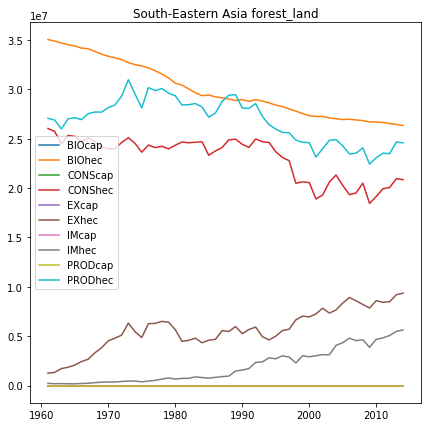

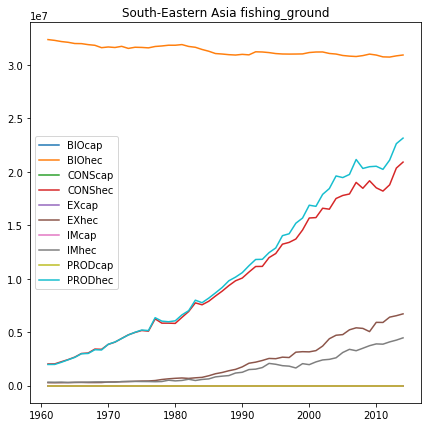

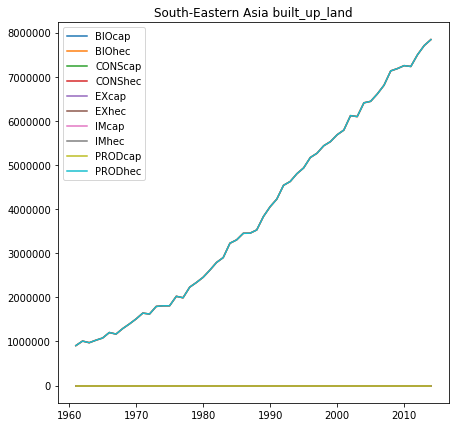

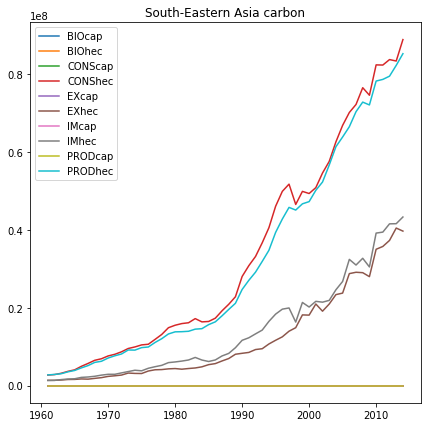

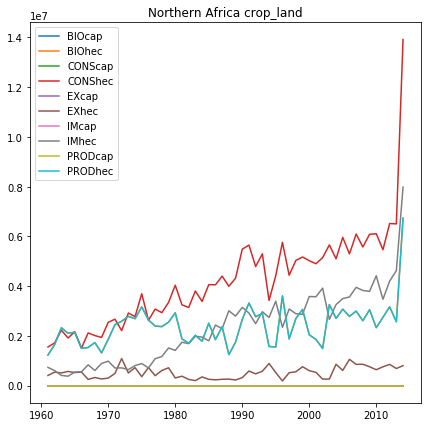

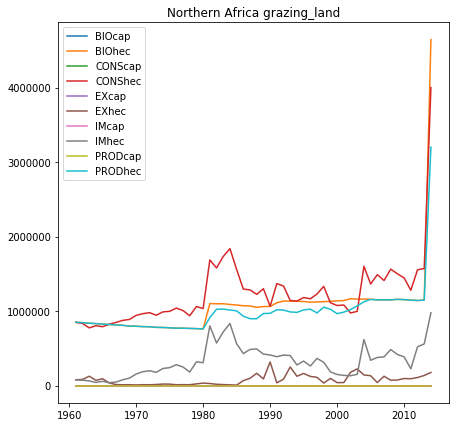

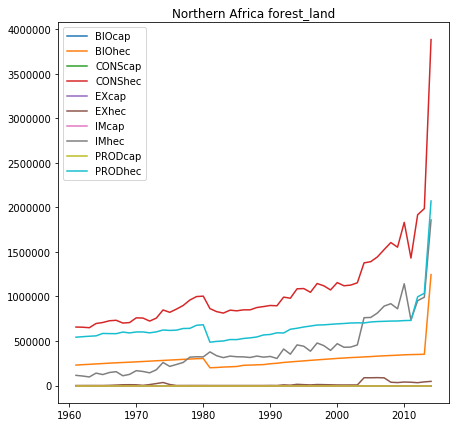

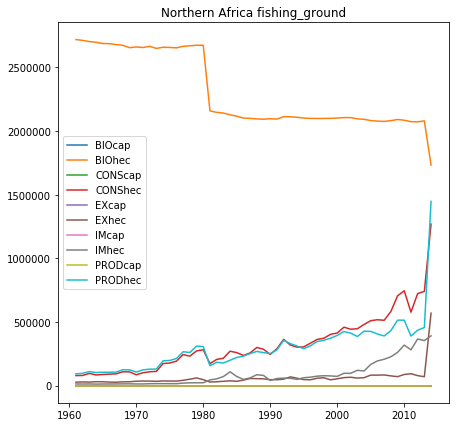

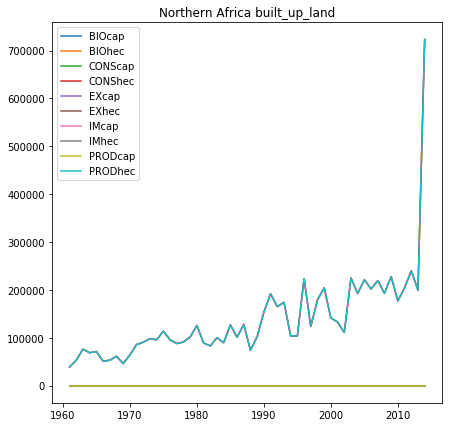

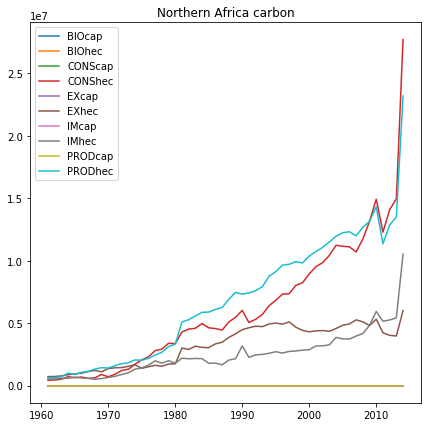

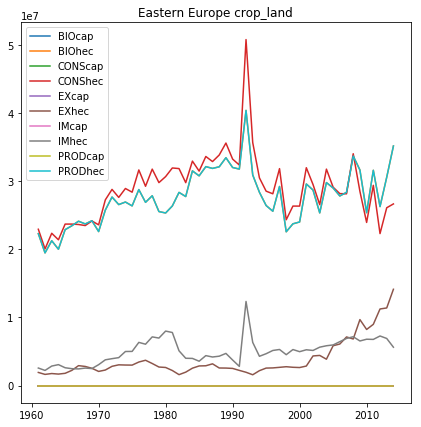

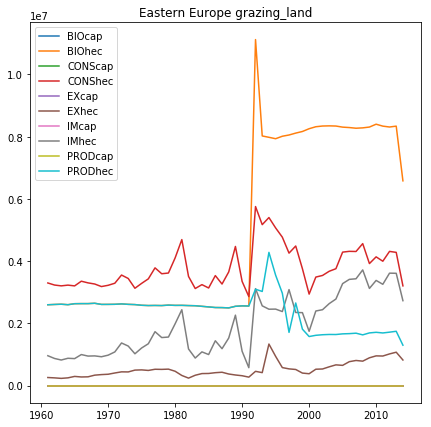

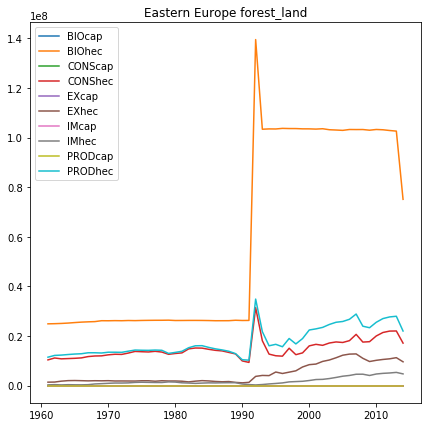

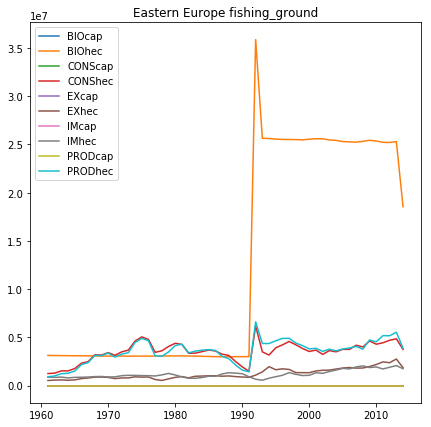

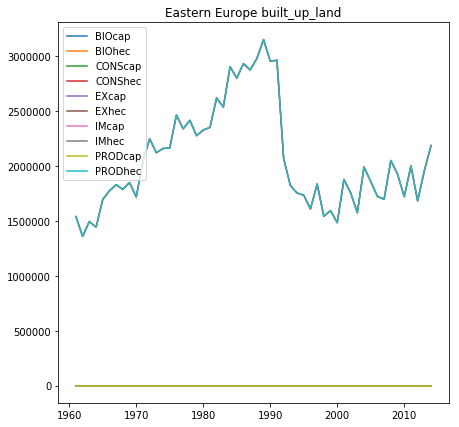

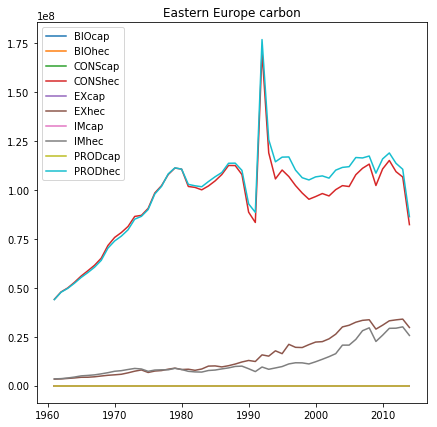

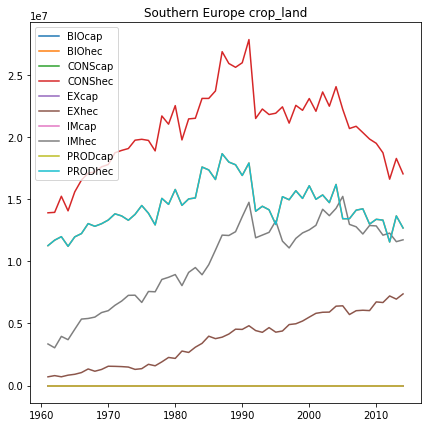

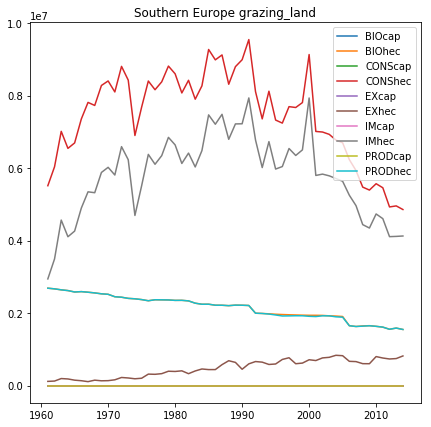

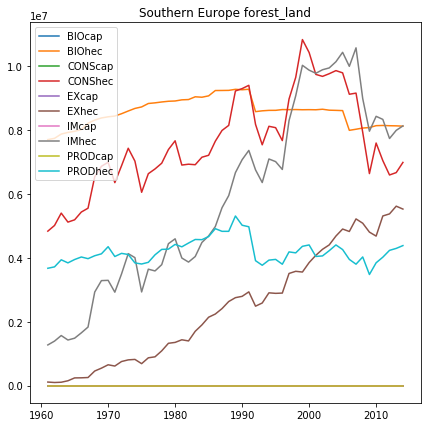

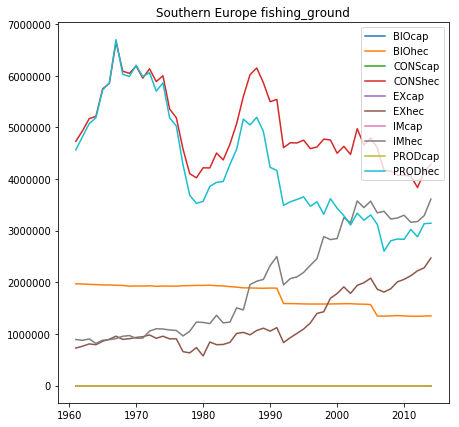

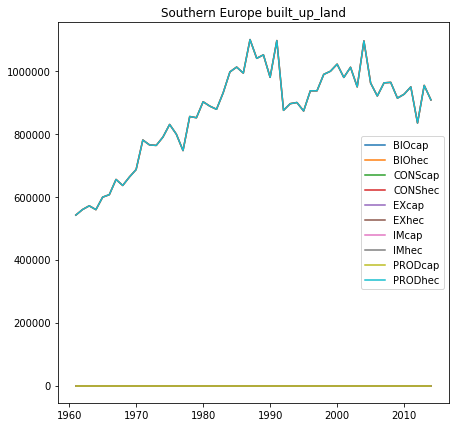

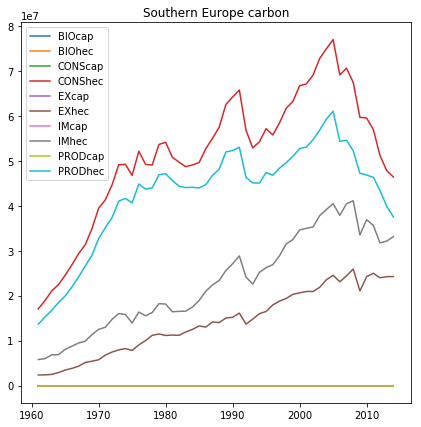

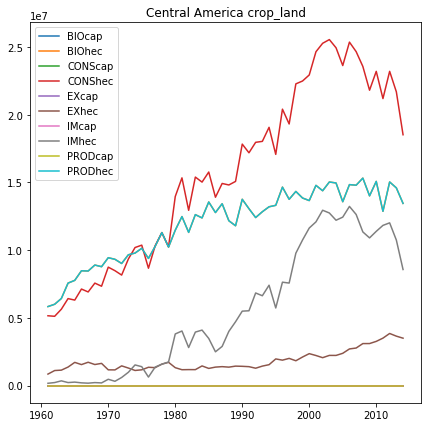

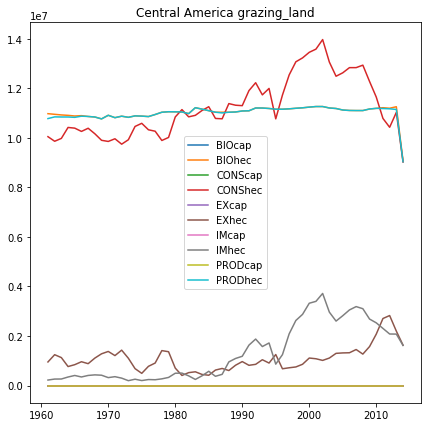

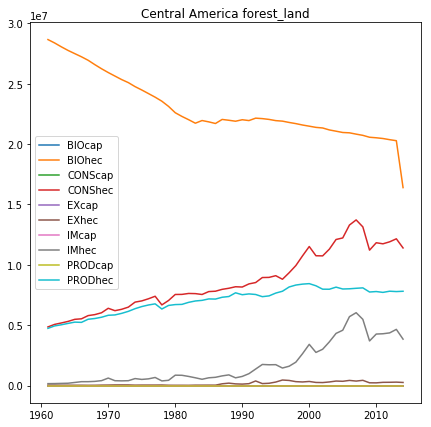

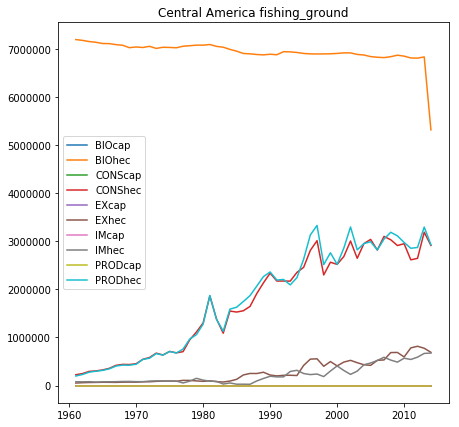

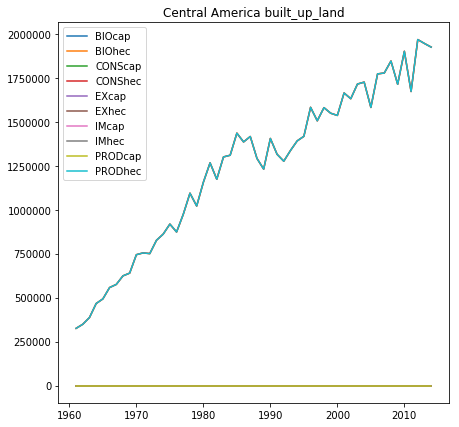

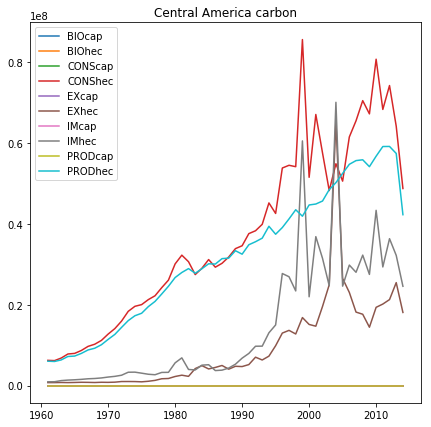

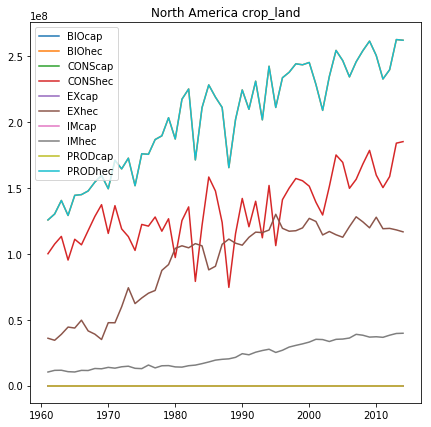

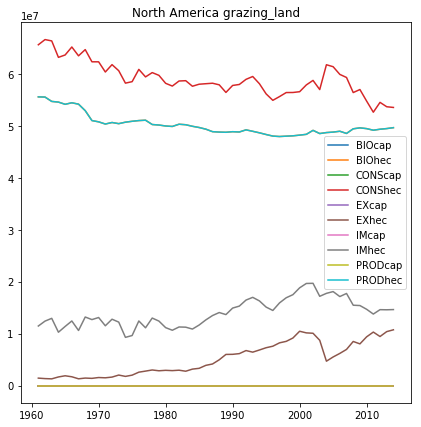

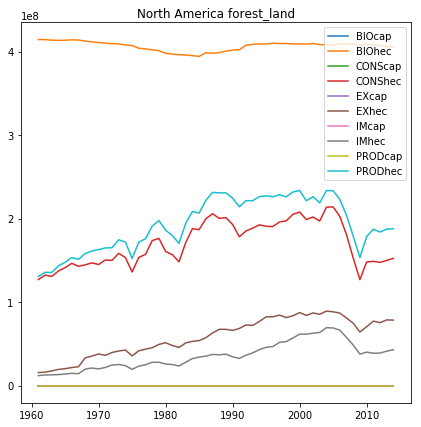

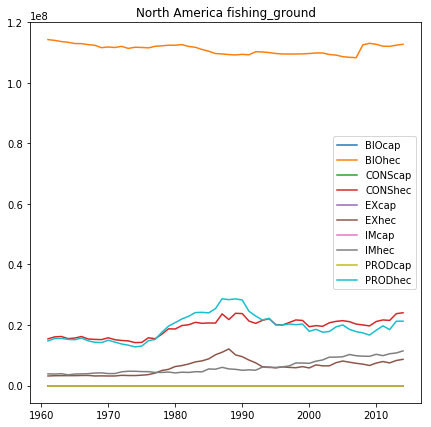

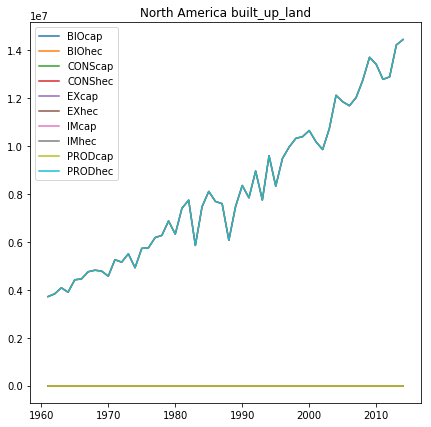

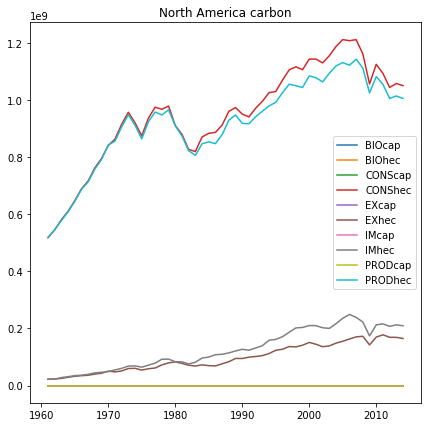

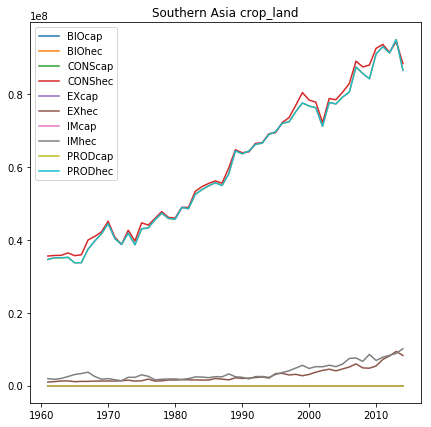

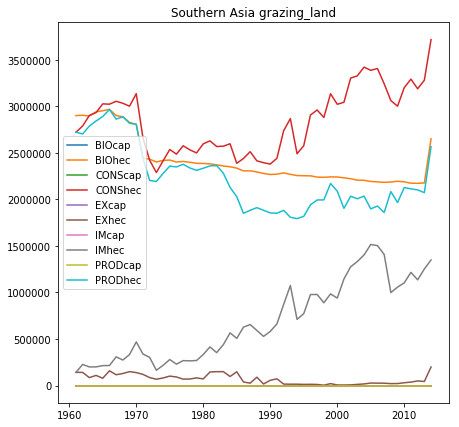

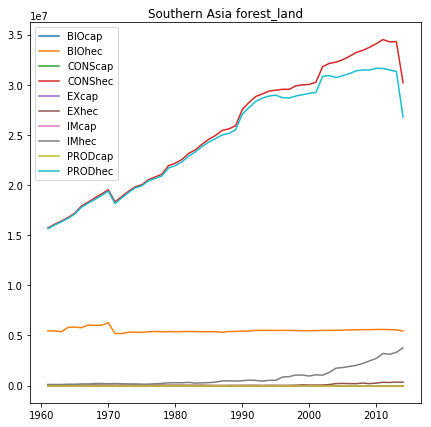

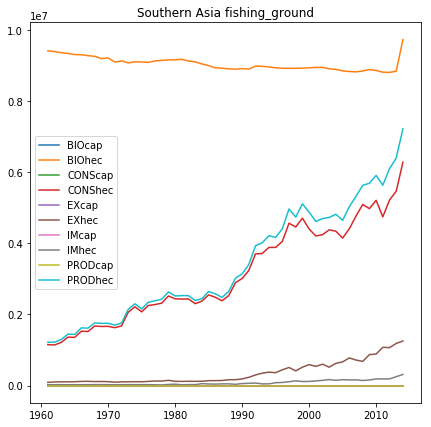

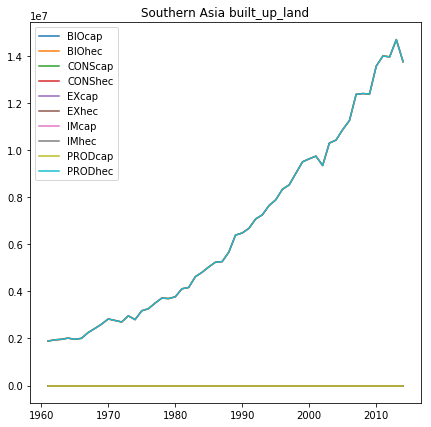

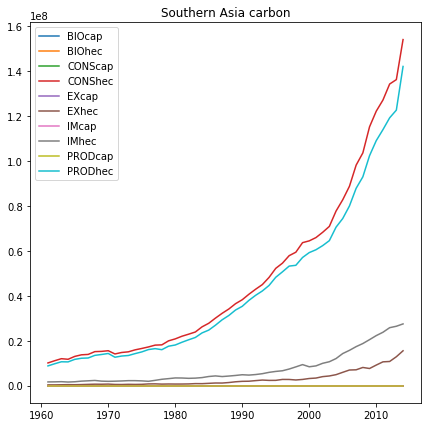

In [124]:
for country in set(ec['UN_subregion']):
    tempdf=ec[ec['UN_subregion']==country]
    for measure in fts:
        temptseries=tempdf.groupby(['record','year']).mean().unstack()[measure]
        plt.figure(figsize=(7,7))
        for rec in temptseries.index:
            plt.plot(temptseries.columns,temptseries.loc[rec],label=rec)
        plt.legend()
        plt.title(country+' '+measure)
        plt.show()